# Barrier Option Pricing with Variance Reduction Techniques

In this notebook, we apply **Monte Carlo variance reduction techniques** to price a **Down-and-Out European Call Option**. The methods used are:

- **Antithetic Variates**: Use negatively correlated paths to reduce variance.
- **Control Variates**: Use the analytically known European Call as a control asset.
- **Convergence Study**: Analyze performance as number of paths increases.

These methods significantly improve estimator efficiency and stability.

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Barrier Call Parameters
S0 = 100      # Initial stock price
K = 100       # Strike
T = 1.0       # Maturity
r = 0.05      # Risk-free rate
sigma = 0.2   # Volatility
B = 90        # Lower barrier
M = 100       # Time steps

np.random.seed(42)

In [33]:
# Barrier Option Pricing

def simulate_barrier_paths(N):
    dt = T / M
    S_paths = np.zeros((N, M+1))
    S_paths[:, 0] = S0
    for t in range(1, M+1):
        Z = np.random.randn(N)
        S_paths[:, t] = S_paths[:, t-1] * np.exp((r - 0.5 * sigma**2) * dt + (sigma * np.sqrt(dt) * Z))
    return S_paths

def down_and_out_call(S_paths):
    S_T = S_paths[:,-1]
    knocked_out = np.any(S_paths <= B, axis=1)
    down_out_payoffs = np.where(~knocked_out, np.maximum(S_T - K, 0), 0)
    return down_out_payoffs

def barrier_mc_price(N):
    S_paths = simulate_barrier_paths(N)
    payoffs = down_and_out_call(S_paths)
    discounted = np.exp(-r * T) * payoffs
    price = np.mean(discounted)
    stderr = np.std(discounted) / np.sqrt(N)
    return price, stderr

price, stderr = barrier_mc_price(50000)
print(f"Barrier MC Price : {price:.4f}")
print(f"MC Standard Error : {stderr:.4f}")

Barrier MC Price : 8.9856
MC Standard Error : 0.0653


In [34]:
# Antithetic Variates

def simulate_barrier_path_antithetic(N):
    dt = T / M
    S_paths = np.zeros((2 * N, M + 1))
    S_paths[:, 0] = S0

    for t in range(1, M + 1):
        Z = np.random.randn(N)
        Z_antithetic = -Z
        Z_total = np.concatenate([Z, Z_antithetic])

        S_paths[:, t] = S_paths[:, t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z_total)

    return S_paths

def barrier_mc_price_antithetic(N):
    S_paths = simulate_barrier_path_antithetic(N)
    payoffs = down_and_out_call(S_paths)
    discounted = np.exp(-r * T) * payoffs
    price = np.mean(discounted)
    stderr = np.std(discounted, ddof=1) / np.sqrt(2 * N)  # 2N paths

    return price, stderr

price, stderr = barrier_mc_price_antithetic(50000)
print(f"Antithetic Price : {price:.4f}")
print(f"Antithetic Standard Error : {stderr:.4f}")

Antithetic Price : 9.0726
Antithetic Standard Error : 0.0466


In [35]:
# Control Variates

def bs_european_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5*sigma**2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)

def control_variate_mc_price(N):
    S_paths = simulate_barrier_paths(N)
    euro_payoff = np.maximum(S_paths[:, -1] - K, 0)
    barrier_payoff = down_and_out_call(S_paths)

    cov = np.cov(barrier_payoff, euro_payoff)[0, 1]
    var = np.var(euro_payoff)
    c = -cov / var

    euro_analytic = bs_european_call(S0, K, T, r, sigma)
    adjusted = barrier_payoff + c * (euro_payoff - euro_analytic)

    discounted = np.exp(-r * T) * adjusted
    price = np.mean(discounted)
    stderr = np.std(discounted) / np.sqrt(N)
    return price, stderr

price, stderr = control_variate_mc_price(50000)
print(f"Control Variate Price : {price:.4f}")
print(f"Control Standard Error : {stderr:.4f}")

Control Variate Price : 8.5335
Control Standard Error : 0.0230


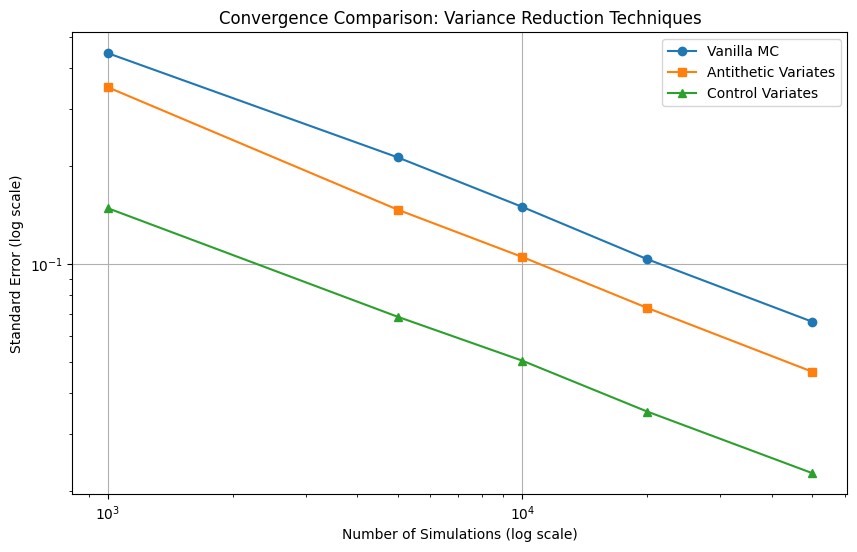

In [31]:
N_list = [1000, 5000, 10000, 20000, 50000]
vanilla_errors = []
antithetic_errors = []
control_errors = []

for N in N_list:
    _, ve = barrier_mc_price(N)
    _, ae = barrier_mc_price_antithetic(N)
    _, ce = control_variate_mc_price(N)
    vanilla_errors.append(ve)
    antithetic_errors.append(ae)
    control_errors.append(ce)

plt.figure(figsize=(10,6))
plt.plot(N_list, vanilla_errors, 'o-', label='Vanilla MC')
plt.plot(N_list, antithetic_errors, 's-', label='Antithetic Variates')
plt.plot(N_list, control_errors, '^-', label='Control Variates')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Simulations (log scale)')
plt.ylabel('Standard Error (log scale)')
plt.title('Convergence Comparison: Variance Reduction Techniques')
plt.grid(True)
plt.legend()
plt.show()

## Summary: Variance Reduction Performance

| Method           | Standard Error (N=50,000) | Remarks |
|------------------|---------------------------|---------|
| Vanilla MC       | ↓ 0.0653                   | Baseline performance |
| Antithetic       | ↓ 0.0466                   | Moderate variance reduction |
| Control Variate  | ↓ 0.0230                   | Best performance, highly efficient |

Control variates produced the **lowest standard error**, leveraging the strong correlation between the barrier and European call. Antithetic variates also improved results with minimal added code.

These tools make Monte Carlo simulations more robust and faster to converge — a must for real-world quantitative finance.